<a href="https://colab.research.google.com/github/laihowo/HK_Carpark_Vacancy/blob/main/Benny_EDA_Park.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [ ]:
import os
park_path = 'park'
park_id = '1ScWo16AqK4vbYfAQpSj_I7-fue4sJ2Iu'
if not os.path.exists(park_path):
  !gdown $park_id -O $park_path
  !unzip -q $park_path

Downloading...
From: https://drive.google.com/uc?id=1ScWo16AqK4vbYfAQpSj_I7-fue4sJ2Iu
To: /content/park
100% 6.96M/6.96M [00:00<00:00, 21.9MB/s]


In [ ]:
import json
import requests
info_url = 'https://resource.data.one.gov.hk/td/carpark/basic_info_all.json'
info_json = json.loads(requests.get(info_url).content)
info_df = pd.json_normalize(info_json['car_park'])

In [ ]:
# @title District Input { run: "auto", vertical-output: true }
import ipywidgets as widgets
from ipywidgets import Layout
from IPython.display import display

# List Item
district_list = info_df['district_en'].unique()
district_list = sorted(np.delete(district_list, -1))

# Create a Dropdown widget
district_picker = widgets.Dropdown(options=district_list)

# Display the widget
display(district_picker)

Dropdown(options=('Central & Western', 'Eastern', 'Islands', 'Kowloon City', 'Kwai Tsing', 'Kwun Tong', 'North…

In [ ]:
# @title Park Input { run: "auto", vertical-output: true }

# List Item
district_df = info_df[info_df['district_en'] == district_picker.value]
park_list = sorted(district_df['name_en'].unique())

# Create a SelectMultiple widget
park_multi_select = widgets.SelectMultiple(
    options=park_list,
    description='Car Parks:',
    rows=len(park_list),
    layout=Layout(width='100%')
)

# Display the widget
display(park_multi_select)

SelectMultiple(description='Car Parks:', layout=Layout(width='100%'), options=('Hong Kong Tennis Centre', 'Hop…

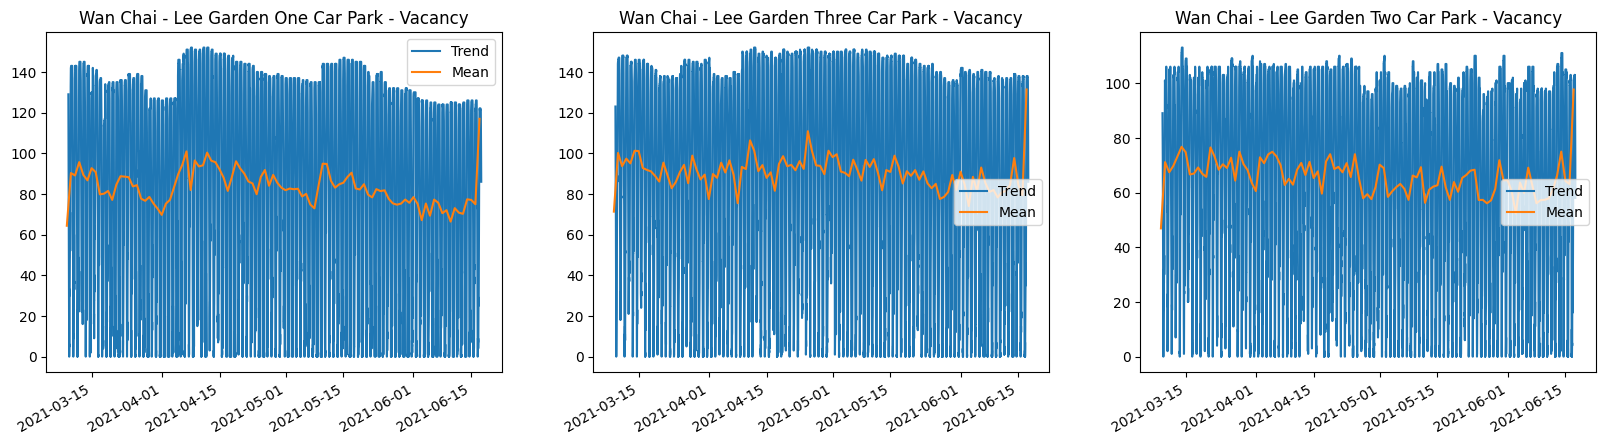

In [ ]:
# @title Trend Output { run: "auto", vertical-output: true }
graph_view = "Daily Mean Line" # @param ["Hourly Median Bar", "Hourly Mean Bar", "Day of Week Line", "Day of Week Bar", "Daily Median Line", "Daily Mean Line"]

park_path = 'park.csv'
park_df_list = []
for item in park_multi_select.value:
  park_df = pd.DataFrame()
  park_id_input = info_df.loc[info_df['name_en'] == item, 'park_id'].iloc[0]

  for file in sorted(os.listdir(park_path)):
    if file == park_id_input+'.csv':
      park_df = pd.read_csv(park_path + '/' + file)
      park_df['lastupdate'] = pd.to_datetime(park_df['lastupdate'])
      park_df.set_index('lastupdate', inplace=True)
      park_df_list.append([park_id_input, park_df])
      break

fig = plt.figure(figsize=(20, 5))
MAX_SUBPLOT = 3
for index, df in enumerate(park_df_list, start=1):
  if len(df[1]) == 0:
    continue
  if index > MAX_SUBPLOT:
    break

  plt_sub = fig.add_subplot(1, MAX_SUBPLOT, index)
  hour_median_df = df[1].groupby('time').median()
  hour_mean_df = df[1].groupby('time').mean()
  dow_median_df = df[1].groupby('day_of_week').median()
  dow_mean_df = df[1].groupby('day_of_week').mean()
  daily_median_df = df[1].resample('1D').median()
  daily_mean_df = df[1].resample('1D').mean()

  if graph_view == 'Hourly Median Bar':
    plt.bar(hour_median_df.index, hour_median_df['vacancy'])

    plt.xlabel('Hour')
    plt.legend(['Median'])

  elif graph_view == 'Hourly Mean Bar':
    plt.bar(hour_mean_df.index, hour_mean_df['vacancy'])

    plt.xlabel('Hour')
    plt.legend(['Mean'])

  elif graph_view == 'Day of Week Line':
    plt.plot(dow_median_df['vacancy'])
    plt.plot(dow_mean_df['vacancy'])

    plt.xlabel('Day of Week')
    plt.legend(['Median', 'Mean'])

  elif graph_view == 'Day of Week Bar':
    plt.bar(dow_median_df.index, dow_median_df['vacancy'])
    plt.bar(dow_mean_df.index, dow_mean_df['vacancy'])

    plt.xlabel('Day of Week')
    plt.legend(['Median', 'Mean'])

  elif graph_view == 'Daily Median Line':
    plt_sub.plot(df[1]['vacancy'])
    plt_sub.plot(daily_median_df['vacancy'])
    plt.legend(['Trend', 'Median'])

  elif graph_view == 'Daily Mean Line':
    plt_sub.plot(df[1]['vacancy'])
    plt_sub.plot(daily_mean_df['vacancy'])
    plt.legend(['Trend', 'Mean'])

  park_id = df[0]
  park_name = info_df.loc[info_df['park_id'] == park_id, 'name_en'].iloc[0]
  plt.title(' - '.join([district_picker.value, park_name, 'Vacancy']))

fig.autofmt_xdate()
plt.show()